# INFO-4604 HW3: Nonlinear Classification 

* Created by Michael Paul on October 17, 2017
* Matthew Kaiser 

##### Deadline: Friday, October 27, 7:00pm MT

## Assignment overview

In this assignment, you will perform image classification. You will experiment with support vector machines (using both linear and nonlinear kernels), as well as the two nonlinear algorithms we discussed recently, decision trees and multilayer perceptron.

The data for this assignment comes from [CIFAR-10](http://www.cs.utoronto.ca/~kriz/cifar.html), an image dataset created at the University of Toronto. Images are labeled with one of 10 classes (see examples below). Some of the classes are similar (e.g., "automobile" and "truck"), though in this dataset, they are defined to be mutually exclusive.

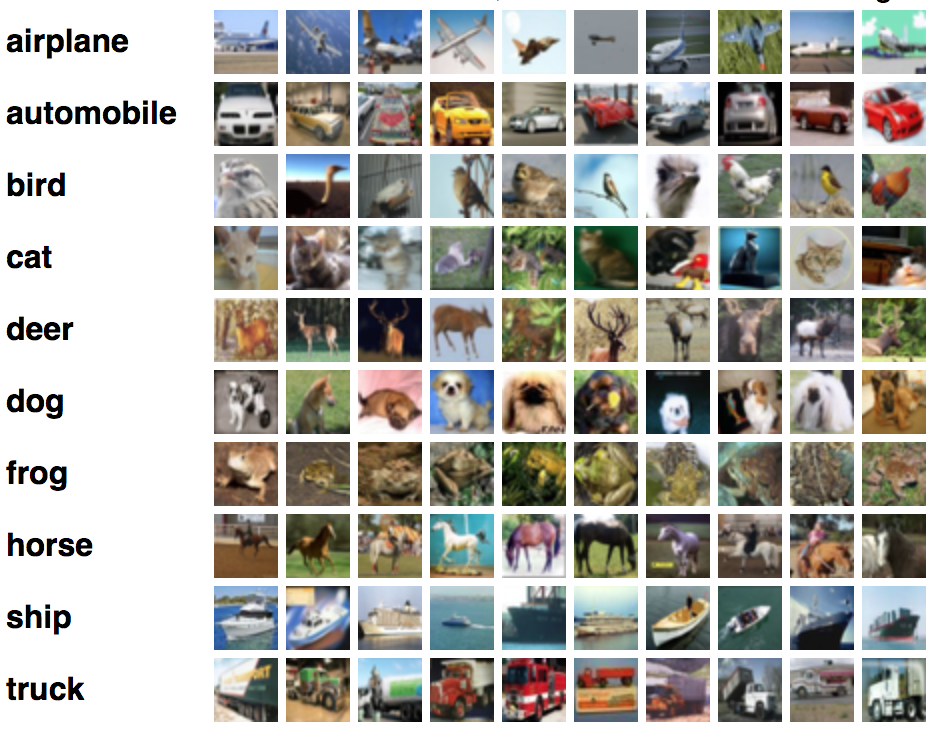

In [9]:
from IPython.display import Image
Image('http://cmci.colorado.edu/classes/INFO-4604/data/hw3_example.png', width=500) 

The images are tiny: 32x32 pixels. This makes it a difficult classification problem, because there is not a lot of detail in the images, but this is actually convenient for the purpose of this assignment, because the small size makes the data easier to work with computationally.

In general, image classification is a challenging machine learning problem, as well as a computationally intensive one. How to define and extract good features is an open challenge $-$ you'll see a little of that here. The CIFAR-10 data contains 50,000 images for training and 10,000 for testing, but for this assignment, you will work with only a sample of 5,000 training images and 2,000 test images. Your classifiers won't be as accurate as classifiers trained on all 50,000 instances, but it will be a lot more manageable to work with a small sample.

### What to hand in

You will submit the assignment on Piazza. A private note to the instructor should be submitted with the subject _"Submission 3 from [your full name]"_ with the submission file(s) as an attachment. The note should be submitted to the `submissions` folder (**not** the `hw3` folder).

Submit a single Jupyter notebook named `hw3lastname.ipynb`, where lastname is replaced with your last name.

If you have any output that is not part of your notebook, you may submit that as a separate document, in a single PDF named `hw3lastname.pdf`. For example, this assignment requires you to create plots. You could do it directly with python using [matplotlib](https://matplotlib.org/), but if you wanted to create them using other software, that's acceptable as long as you put all of the figures in a single document and you clearly label them with the corresponding deliverable number.

### Submission policies

- **Collaboration:** You are allowed to work with up to 3 people besides yourself. You are still expected to write up your own solution. Each individual must post their own submission on Piazza, and you must list the names of your group members in your Piazza note when you submit.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you are out of late days, you can receive no more than 80% credit for an assignment that is up to one day late, and no more than 60% credit for an assignment that is more than one day late. 

### Asking for help

You are encouraged to ask questions on [Piazza](https://piazza.com/colorado/fall2017/info4604). Do not post anything that you are turning in, but you can describe general things you observe about the algorithms. You may ask questions to help with debugging, but do not post your code. You can share error messages and describe what you are trying to do with your code, but try not to write enough to "give away" the solution.

Questions specifically about this assignment should be posted in the `hw3` folder. If you have clarifications about what is being asked, you can tag the instructor in your post. If you have more general programming questions (for example, if you are having trouble installing packages, running the notebook, or working with `numpy`), post in the `python` folder. (You can post in multiple folders if both are relevant.)


## Getting started

Begin by downloading and loading the data, stored in CSV format. The first column in each CSV file is the class label (the $y$ value), and the remaining columns are the feature values. The [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class is used to standardize the feature values using z-score normalization.

It may take a minute to run the cell below. In general, you'll notice that code in this assignment will take longer to execute than in HW2, even though the HW2 data had a similar number of instances and number of features. Why? The reason is that the image features are *dense*, meaning that all feature values need to be stored and used in the algorithm. In the tweets in HW2, the features were *sparse*, meaning that most of the feature values were simply $0$, and therefore didn't need to be stored in memory and in many cases could be skipped during computation in the learning algorithms.

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

print('Loading training data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_raw_train.csv', header=None)

rawY = df.iloc[0:, 0].values
rawX = df.iloc[0:, 1:].values
scalar.fit(rawX)
rawX = scalar.transform(rawX)

print('...done.')
print('Loading test data...')

df = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/cifar_raw_test.csv', header=None)

rawY_test = df.iloc[0:, 0].values
rawX_test = df.iloc[0:, 1:].values
scalar.fit(rawX_test)
rawX_test = scalar.transform(rawX_test)

print('...done.')


Loading training data...


C:\Users\Test\Anaconda\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


...done.
Loading test data...
...done.


### What do the columns mean?

The columns in the above CSV files correspond to color values of each pixel of the image (after the first column, which is the label). A 32x32 image has 1,024 pixels. The first 1,024 features are the red channel values of each pixel (values from 0 to 255), the second 1,024 features are the green channel values, and the last 1,024 features are the blue channel values, for a total of 3,072 features.

We refer to this as the "raw" data, because it simply encodes the image itself. You will load a different version of the dataset with more abstract features later on in this notebook.

### Establishing a baseline

Before experimenting with building classifiers, it can be good to come up with a "baseline" accuracy that you expect your classifiers to outperform. This is helpful for contextualizing how good your classifiers are doing.

`sklearn` provides a class called [`DummyClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) which implements a few different naive baselines that don't learn from features. In the code below, we use the `most_frequent` strategy, which simply creates a classifier that always predicts the majority class in the training data.

The ten classes in this dataset are roughly evenly distributed, so the majority class baseline only has an accuracy of 10%. If you get an accuracy of 10% or lower in your experiments later, you'll know that your classifier is not learning anything useful.

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

classifier = DummyClassifier(strategy='most_frequent')
classifier.fit(rawX, rawY)

print("Training accuracy: %0.6f" % accuracy_score(rawY, classifier.predict(rawX)))
print("Testing accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

Training accuracy: 0.104000
Testing accuracy: 0.108500


## Problem 1: Support vector machines

We will begin by trying to classify the data using support vector machines (SVMs). For this problem, you will use `sklearn`'s [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class, which implements a variety of SVM kernels. To handle multiple classes, `SVC` uses the "all pairs" algorithm (called "one-vs-one" in the `sklearn` documentation) for multiclass classification. (In contrast, the `SGDClassifier` you used in HW2 uses "one-vs-rest" by default, so you may get different results if you try to compare the two.)

You can define the kernel with the `kernel` keyword argument. Additional keyword arguments can specify various hyperparameters specific to the kernels. You should try four different kernels:

- `linear`
- `poly` with `degree=2` (a quadratic kernel)
- `poly` with `degree=3` (a 3rd-degree polynomial kernel)
- `rbf` (the radial basis function or Gaussian kernel)

You should also set the hyperparameter $C$ with the keyword argument `C`, which controls the tradeoff between regularization (increasing the margin) and training performance (decreasing the loss). `C` is similar to `alpha` in `SGDClassifier`, but the inverse: increasing `alpha` increases regularization, while increasing `C` decreases regularization.

### Classifying the raw data [2 points]

Let's start by using the data described above, which contains 3,072 features representing the RGB color values of the 1,024 pixels in the 32x32 images.

While the data was already downsampled to 5,000 training instances, it still takes a minute to train an SVM on this data. To speed things up while starting out, you should instead use only the first 1,000 training instances. This is already done in the code for you in the first block, which you can use as a starting point, where `rawX[:1000]` and `rawY[:1000]` are selecting the first 1000 entries of those arrays. (The dataset of 5,000 was already sorted in random order, so taking the first 1,000 rather than a random 1,000 will not bias the data distribution.)

#### Deliverable 1.1: For each of the four kernels listed above, calculate the training and test accuracy when setting `C` to each of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]$. Fill out the table below, where for each kernel you give the value of $C$ that gave the best test accuracy, as well as the test accuracy itself at that value of $C$.

| Kernel | $C$ | Test accuracy | 
|--------|-----|---------------|
| Linear |0.001|     0.326     | 
| Poly-2 | 100 |     0.2675    | 
| Poly-3 | 10  |     0.2725    | 
| RBF    |  1  |     0.36      |

In [4]:
from sklearn.svm import SVC

# code for 1.1 here

# Note the random_state argument. Like in HW2, you should keep this argument
# in every classifier constructor so that you get consistent results.
print("Linear Kernel")
C= [.0001, .001, .01, .1, 1, 10, 100, 1000]
for curc in C:
    print ("C iterations...")
    classifier = SVC(kernel='linear', C =curc, random_state=123)
    classifier.fit(rawX[:1000], rawY[:1000])

    print("Training accuracy: %0.6f" % accuracy_score(rawY[:1000], classifier.predict(rawX[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

    
degree = [2, 3]    
for curdegree in degree:
    print ("Poly")
    C2= [.0001, .001, .01, .1, 1, 10, 100, 1000]
    for curc2 in C2:
       
        
        print ("C iterations...")
        classifier = SVC(kernel='poly', C =curc2, random_state=123, degree= curdegree)
        classifier.fit(rawX[:1000], rawY[:1000])

        print("Training accuracy: %0.6f" % accuracy_score(rawY[:1000], classifier.predict(rawX[:1000])))
        print("Test accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))
            
print("RBF")
C3= [.0001, .001, .01, .1, 1, 10, 100, 1000]
for curc3 in C3:
    print ("C iterations...")
    classifier = SVC(kernel='rbf', C =curc3, random_state=123)
    classifier.fit(rawX[:1000], rawY[:1000])

    print("Training accuracy: %0.6f" % accuracy_score(rawY[:1000], classifier.predict(rawX[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(rawY_test, classifier.predict(rawX_test)))

            
    

Linear Kernel
C iterations...
Training accuracy: 0.411000
Test accuracy: 0.320000
C iterations...
Training accuracy: 0.712000
Test accuracy: 0.326000
C iterations...
Training accuracy: 0.998000
Test accuracy: 0.298500
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.299000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.299000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.299000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.299000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.299000
Poly
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.162000
Test accuracy: 0.123500
C iterations...
Training accuracy: 0.707000
Test accuracy: 0.268000
C iterations...
Training accuracy: 0.991000
Test accuracy: 0.269500
C iterations...
Training accu

### Using better features [4 points]

Using the color values of each individual pixel typically does not yield good image classification results. The exact color value of a specific pixel is not likely to be associated with a specific class in a way that generalizes well. Typically, more general and abstract features are extracted from images before using them in learning algorithms.

For the remainder of this assignment, we will use a different, preprocessed version of the dataset containing various image features rather than the original pixel representation. The data has two broad types of features:

- *DAISY* is an algorithm for extracting "descriptors" of different parts of an image, such as edges. These features were extracted using [scikit-image](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.daisy).
- *Color histograms* provide counts of the number of times ranges of colors appear within an image (or section of an image), providing a summary of the color distribution rather than specifying the colors of individual pixels. For this data, color histogram features are extracted from the entire image as well as each quadrant of the image. These features were extracted using the `calcHist` function of the [OpenCV](https://opencv.org/) computer vision library.

To load the new data, run the block of code below:

In [1]:
#run this for testing purposes on a cell such that a whole cell isn't needed for initialization
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.svm import SVC

scalar = StandardScaler()

print('Loading training data...')

df = pd.read_csv('https://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_train.csv', header=None)

Y = df.iloc[0:, 0].values
X = df.iloc[0:, 1:].values
scalar.fit(X)
X = scalar.transform(X)

print('...done.')
print('Loading test data...')

df = pd.read_csv('https://cmci.colorado.edu/classes/INFO-4604/data/cifar_features_test.csv', header=None)

Y_test = df.iloc[0:, 0].values
X_test = df.iloc[0:, 1:].values
scalar.fit(X_test)
X_test = scalar.transform(X_test)

print('...done.')

Loading training data...
...done.
Loading test data...
...done.


<br /><br />


#### Deliverable 1.2: Redo the experiments you did for 1.1 using the data with new features. Fill in the table below, once again with the best test accuracies and the $C$ values that gave those accuracies:

| Kernel | $C$ | Test accuracy | 
|--------|-----|---------------|
| Linear |0.001|   0.429       | 
| Poly-2 |100&1000  |   0.3765      | 
| Poly-3 | 10  |   0.295      | 
| RBF    |10&100&1000   |   0.486        |<br>


#### Deliverable 1.3: Compare the results from 1.2 to the results from 1.1. Comment on three aspects: (i) Overall, which version (raw data in 1.1 or preprocessed data in 1.2) resulted in better performance? (ii) Was the relative performance of the four kernels (e.g., `rgb` outperforms `linear`) similar across the two versions? (iii) Were the optimal $C$ values similar across the two versions?

i) Preprocessed data overall performed much better than the original raw data. ii) RBF outperforms all other kernels across beoth version.  Linear scores second best across both datasets.  Poly-3 performs better on the raw data while Poly-2 performs better on preprocessed data.  iii) The optimal C value for Poly-2 is now a tie between the previous 100 and now added 1000 value.  The RBF kernel is quite different as setting C to be 1 scored the best on testing data but now the 10, 100, and 1000 are scoring the highest and tieing at 0.486 accuracy.

In [11]:
print("Linear Kernel")
C= [.0001, .001, .01, .1, 1, 10, 100, 1000]
for curc in C:
    print ("C iterations...")
    classifier = SVC(kernel='linear', C =curc, random_state=123)
    classifier.fit(X[:1000], Y[:1000])

    print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

    
degree = [2, 3]    
for curdegree in degree:
    print ("Poly")
    C2= [.0001, .001, .01, .1, 1, 10, 100, 1000]
    for curc2 in C2:
       
        
        print ("C iterations...")
        classifier = SVC(kernel='poly', C =curc2, random_state=123, degree= curdegree)
        classifier.fit(X[:1000], Y[:1000])

        print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
        print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
            
print("RBF")
C3= [.0001, .001, .01, .1, 1, 10, 100, 1000]
for curc3 in C3:
    print ("C iterations...")
    classifier = SVC(kernel='rbf', C =curc3, random_state=123)
    classifier.fit(X[:1000], Y[:1000])

    print("Training accuracy: %0.6f" % accuracy_score(Y[:1000], classifier.predict(X[:1000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))


Linear Kernel
C iterations...
Training accuracy: 0.483000
Test accuracy: 0.379000
C iterations...
Training accuracy: 0.756000
Test accuracy: 0.429000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.403500
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.407000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.407000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.407000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.407000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.407000
Poly
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.112000
Test accuracy: 0.099000
C iterations...
Training accuracy: 0.168000
Test accuracy: 0.115500
C iterations...
Training accuracy: 0.793000
Test accuracy: 0.325000
C iterations...
Training accuracy: 1.000000
Test accuracy: 0.374000
C iterations...
Training accu

<br /><br />

### Understanding kernels [8 points]

Above, we only used the first 1000 training instances (out of 5000) for the sake of speed. Now let's vary the amount of training data by changing the `1000` in `X[:1000]` and `Y[:1000]` to other values.

For these experiments, let's focus on the `rbf` kernel (which you should have found outperformed the others) and the `linear` kernel. Set `C` to $0.001$ for the linear kernel and $10.0$ for the RBF kernel. Use the preprocessed data rather than the raw data (i.e., `X` and `Y` instead of `rawX` and `rawY`).

#### Deliverable 1.4: Train a linear and RBF kernel classifier using the first $N$ training instances (where $N=1000$ in the earlier problems) when $N$ is each of $[20, 50, 100, 200, 400, 800, 1500, 3000, 5000]$ and calculate the test accuracy. Create a line plot where the x-axis is $N$ and the y-axis is test accuracy. There should be two lines, one for each kernel.

Solution plotted below

#### Deliverable 1.5: Nonlinear classifiers can learn more complex patterns than linear models, but they are at higher risk of overfitting because they have more parameters to learn. Keeping this in mind, what do you observe in your plot from 1.4? What might you conclude about the advantage of nonlinear classification versus linear classification based on the size of the training data?

When assesing a small set of training data it is advantageous to use a linear classifier. As the size amount of data to be assesed increases the advantage a nonlinear classifier(rbf) is seen between the 100 and 200 n instance parameters as the testing accuracy for rbf now performs better than our linear classifier.  When we look at 20 instances linear scores 0.1415 while RBF scores 0.12 however these are low testing scores so I think the finding that RBF scores 0.579 while linear only scores 0.539 on 5000 instances is more significant due to the larger gap and higher accuracies.

In [5]:

# code for 1.4 here
print("RBF")
N1= [20,50,100,200,400,800,1500,3000,5000]
train1 = []
for n1 in N1:
    print ("N iterations...")
    classifier = SVC(kernel='rbf', C = 10, random_state=123)
    classifier.fit(X[:n1], Y[:n1])
    print("N: " , n1)
    score = accuracy_score(Y_test, classifier.predict(X_test))
    train1.append(score)
    
    print("Training accuracy: %0.6f" % score)
    print("Test accuracy: %0.6f" % score)

RBF
N iterations...
N:  20
Training accuracy: 0.120000
Test accuracy: 0.120000
N iterations...
N:  50
Training accuracy: 0.224000
Test accuracy: 0.224000
N iterations...
N:  100
Training accuracy: 0.247500
Test accuracy: 0.247500
N iterations...
N:  200
Training accuracy: 0.337000
Test accuracy: 0.337000
N iterations...
N:  400
Training accuracy: 0.397000
Test accuracy: 0.397000
N iterations...
N:  800
Training accuracy: 0.436000
Test accuracy: 0.436000
N iterations...
N:  1500
Training accuracy: 0.482500
Test accuracy: 0.482500
N iterations...
N:  3000
Training accuracy: 0.545000
Test accuracy: 0.545000
N iterations...
N:  5000
Training accuracy: 0.579000
Test accuracy: 0.579000


In [10]:
print("Linear Kernel")
N= [20,50,100,200,400,800,1500,3000,5000]
train = []
for n in N:
    print ("N iterations...")
    classifier = SVC(kernel='linear', C =0.001, random_state=123)
    classifier.fit(X[:n], Y[:n])
    print("N: " , n)
    score = accuracy_score(Y_test, classifier.predict(X_test))
    train.append(score)
    
    print("Training accuracy: %0.6f" % score)
    print("Test accuracy: %0.6f" % score)

Linear Kernel
N iterations...
N:  20
Training accuracy: 0.141500
Test accuracy: 0.141500
N iterations...
N:  50
Training accuracy: 0.236500
Test accuracy: 0.236500
N iterations...
N:  100
Training accuracy: 0.248000
Test accuracy: 0.248000
N iterations...
N:  200
Training accuracy: 0.331000
Test accuracy: 0.331000
N iterations...
N:  400
Training accuracy: 0.375500
Test accuracy: 0.375500
N iterations...
N:  800
Training accuracy: 0.420500
Test accuracy: 0.420500
N iterations...
N:  1500
Training accuracy: 0.453000
Test accuracy: 0.453000
N iterations...
N:  3000
Training accuracy: 0.494500
Test accuracy: 0.494500
N iterations...
N:  5000
Training accuracy: 0.539000
Test accuracy: 0.539000


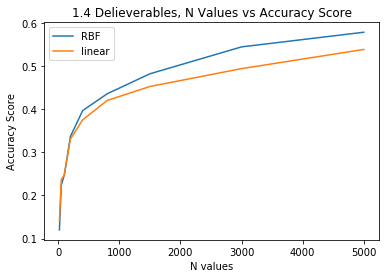

In [12]:
import matplotlib.pyplot as plt
plt.title("1.4 Delieverables, N Values vs Accuracy Score")
plt.xlabel("N values")
plt.ylabel("Accuracy Score")
plt.plot(N1, train1, label = "RBF")
plt.plot(N, train, label = "linear")
plt.legend()
plt.show()

<br /><br />

In class, we learned that the RBF kernel has a hyperparameter $\gamma$ which can affect overfitting. You can set the value of $\gamma$ with the keyword argument `gamma`.

For these experiments with `gamma`, it is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

#### Deliverable 1.6: Train an RBF SVM (with $C=10.0$) where `gamma` is each of: [`1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`, `1e-7`], where `1eM` is scientific notation meaning $1 \times 10^M$. For each value of `gamma`, compute both the training accuracy and test accuracy. Record the values in the table below:

| `gamma` | Training accuracy | Test accuracy | 
|--------|--------------------|---------------|
| `1e-2` |          1.0       |    0.1315     | 
| `1e-3` |           1.0      |    0.5555     | 
| `1e-4` |           0.8658   |    0.572      | 
| `1e-5` |           0.5972   |   0.5145            |
| `1e-6` |           0.4302         |      0.401         | 
| `1e-7` |           0.223         |      0.2265         | 

#### Deliverable 1.7: Describe what you observe in the table for 1.6, describing the effect of `gamma` in terms of the bias/variance tradeoff.

For our largest gamma values we are scoring perfectly on training data but not the best on testing data.  As our gamma decreases, our training scores also decrease.  Our peak test score does occur while gamma has only sunk to 1e-4 which brings the bias/variance tradeoff into discussion as even though we are lowering our gamma values becuase initally the lowering of training score, lowering of weights, and rise in variance was benefical at first, after the 1e-4 gamma value, the scoring decreases for both training and testing data.  By the end with the smallest gamma values we are now underfitting our data rather than overfitting.

In [13]:
# code for 1.6 here
gamma = [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
for g in gamma:
    print ("Gamma iterations...")
    classifier = SVC(kernel='rbf', C=10.0, random_state=123, gamma=g)
    classifier.fit(X[:5000], Y[:5000])
    print("Gamma: " , g)
    print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])))
    print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

Gamma iterations...
Gamma:  0.01
Training accuracy: 1.000000
Test accuracy: 0.131500
Gamma iterations...
Gamma:  0.001
Training accuracy: 1.000000
Test accuracy: 0.555500
Gamma iterations...
Gamma:  0.0001
Training accuracy: 0.865800
Test accuracy: 0.572000
Gamma iterations...
Gamma:  1e-05
Training accuracy: 0.597200
Test accuracy: 0.514500
Gamma iterations...
Gamma:  1e-06
Training accuracy: 0.430200
Test accuracy: 0.401000
Gamma iterations...
Gamma:  1e-07
Training accuracy: 0.223000
Test accuracy: 0.226500


<br />

### Understanding features [5604: 3 points; 4604: +1 EC]

As stated earlier, there are two types of features in the preprocessed data: DAISY features and color histogram features. 

For this last SVM problem, create two additional copies of `X` and `X_test`: one that only contains the DAISY features (the first $1664$ columns of `X`), and one that only contains the histogram features (the last $320$ columns of `X`). Give the copies new variable names, because the rest of this notebook will continue to use the previous definitions of `X` and `X_test`.

Experiment with these two different feature sets. For these experiments, use a linear SVM with $C=0.001$ and an RBF SVM with $C=10.0$.

#### Deliverable 1.8: Compute the test accuracy when using only the DAIRY features (for both linear and RBF kernels), and compute the test accuracy when using only histogram features (for both kernels). Describe what you observe. How do the two feature sets compare to each other? How do the two feature sets compare to using both types of features combined? 

For both the color histogram and Daisy features, RBF outperforms the linear kernel. However more significantly, Daisy features outperform color histogram features to the point that a linear kernel using Daisy features outperformed an RBF kernel using color histogram features.  We don't score quite as high on either kernel once we isolate our features compared to when we were using both sets of features.

In [14]:
# code for 1.8 here
print('Daisy Features')

print('RBF')
classifier = SVC(kernel='rbf', C=10.0, random_state=123)
classifier.fit(X[:1664], Y[:1664])
print("Training accuracy: %0.6f" % accuracy_score(Y[:1664], classifier.predict(X[:1664])))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print('Linear')
classifier = SVC(kernel='linear', C=0.001, random_state=123)
classifier.fit(X[:1664], Y[:1664])
print("Training accuracy: %0.6f" % accuracy_score(Y[:1664], classifier.predict(X[:1664])))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print('Color Histogram Features')

print('RBF')
classifier = SVC(kernel='rbf', C=10.0, random_state=123)
classifier.fit(X[4680:], Y[4680:])
print("Training accuracy: %0.6f" % accuracy_score(Y[4680:], classifier.predict(X[4680:])))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print('Linear')
classifier = SVC(kernel='linear', C=0.001, random_state=123)
classifier.fit(X[4680:], Y[4680:])
print("Training accuracy: %0.6f" % accuracy_score(Y[4680:], classifier.predict(X[4680:])))
print("Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

Daisy Features
RBF
Training accuracy: 1.000000
Test accuracy: 0.495500
Linear
Training accuracy: 0.714543
Test accuracy: 0.460000
Color Histogram Features
RBF
Training accuracy: 1.000000
Test accuracy: 0.375500
Linear
Training accuracy: 0.850000
Test accuracy: 0.364500




## Problem 2: Decision Trees [6 points]

Let's now experiment with decision tree classification on the preprocessed data using `sklearn`'s [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class.

There are a variety of hyperparameters that can be adjusted to control the bias/variance tradeoff. We will experiment with two:

- `max_depth` is the maximum depth of the decision tree, as we learned about in class.
- `min_samples_leaf` is the minimum number of training instances that must be remaining at a leaf node to make a final prediction. If the algorithm tries to split a node and fewer than this minimum instances would end up in the leaf, then the algorithm will stop expanding down that path.

As with SVMs, a bit of code is in the cell below to help you get started.


#### Deliverable 2.1: Experiment with setting `max_depth` to each of $[3, 8, 10, 14, 100]$ and setting `min_samples_leaf` to each of $[1, 5, 10, 15, 20, 50]$. For each combination of these two hyperparameters, record the training and test accuracies in the large table below. It will take a few minutes to do all of these combinations. It is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

| `max_depth` | `min_samples_leaf` | Training accuracy | Test accuracy | 
|-------------|--------------------|-------------------|---------------|
| $3$         |   $1$              |       0.290200            |   0.270000    |
| $3$         |   $5$              |       0.290200            | 0.270000    |
| $3$         |   $10$             |       0.290200            | 0.270000    |
| $3$         |   $15$             |       0.290200            | 0.270000     |
| $3$         |   $20$             |       0.290200            |  0.270000   |
| $3$         |   $50$             |       0.290200            |    0.270000  |
| $8$         |   $1$              | 0.550400          |       0.327500        |
| $8$         |   $5$              |     0.538000      |   0.333500        |
| $8$         |   $10$             |     0.519600      |  0.331000             |
| $8$         |   $15$             |      0.513400     |  0.334500         |
| $8$         |   $20$             |      0.502400     |  0.334000        |
| $8$         |   $50$             |     0.443800      |  0.330000         |
| $10$        |   $1$              |   0.709200        |  0.290500        |
| $10$        |   $5$              |    0.653200       |  0.306000       |
| $10$        |   $10$             |    0.600000       |  0.326000       |
| $10$        |   $15$             |    0.568800       |  0.325500        |
| $10$        |   $20$             |    0.545600       |  0.322000             |
| $10$        |   $50$             |   0.451400        |  0.328000         |
| $14$        |   $1$              |   0.926600        |  0.291500      |
| $14$        |   $5$              |   0.768600        |  0.291000             |
| $14$        |   $10$             |   0.648800        |  0.313500             |
| $14$        |   $15$             |   0.595600                |0.315500     |
| $14$        |   $20$             |   0.561400        |  0.319000          |
| $14$        |   $50$             |   0.451400        |  0.328000        |
| $100$       |   $1$              |   1.00                |   0.2930        |
| $100$       |   $5$              |     0.7838          |  0.2935             |
| $100$       |   $10$             |       0.652400  |   0.312000            |
| $100$       |   $15$             |   0.595400          |     0.315000    |
| $100$       |   $20$             |  0.561400          |  0.319000      |
| $100$       |   $50$             |  0.451400           |0.328000            |

#### Deliverable 2.2: Based on your observations, as well as what you know about these two hyperparameters, describe the effects of `max_depth` and `min_samples_leaf` on the classifier performance and bias/variance tradeoff, including anything you observe about particular combinations of the two hyperparameters.

max_depth limits how far down the tree our algorithm will traverse. I have learned that as we increase our max_depth overfitting increases in class.As well I noticed that as we increase our depth our testing scores don't improve even though the model took much longer to train than the model will a max_depth of 14. min_samples_leaf sets the minimum number of samples necessary to reach a leaf node. I noticed that as min_samples_leaf increases the training data may not necessarily increase, the testing accuracy increases or stays constant in almost every instance.  I notcied that when we look at trees with smaller max_depth the min_samples_leaf which produce the best testing accuracy is between 10 and 20, however, for deeper trees the best testing scores are produced by trees with 50 set as their min_samples_leaf hyperparameter.  


<br />

It seems decision trees do not perform especially well on this dataset. In class, we learned that *random forests* can combine a number of different decision trees to improve performance. This is easy to run in `sklearn` with the [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class. It uses most of the arguments that `DecisionTreeClassifier` supports. The argument `n_estimators` specifies the number of decision trees to train.

#### Deliverable 2.3: Train a random forest using the best settings of `max_depth` and `min_samples_leaf` from 2.1 and record the test accuracies in the table below. Set `n_estimators` to each of $[10, 50, 100, 300]$. You should see a substantial increase in accuracy over using an individual decision tree.

| `n_estimators` | Test accuracy | 
|----------------|---------------|
| $10$           | 0.405000              |
| $50$           | 0.445000              |
| $100$          |   0.458000            |
| $300$          |    0.463500           |

In [16]:
from sklearn.tree import DecisionTreeClassifier
# code for 2.1 here

MD = [3,8,10,14,100] #maxdepth
ML = [1,5,10,15,20,50] #minleaf
for depth in MD:
    print("depth: " , depth)
    for leaf in ML:
        
        classifier = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=123)
        classifier.fit(X[:5000], Y[:5000])

        print("leaf: " , leaf , "Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
        

depth:  3
leaf:  1 Training accuracy: 0.290200 Test accuracy: 0.270000
leaf:  5 Training accuracy: 0.290200 Test accuracy: 0.270000
leaf:  10 Training accuracy: 0.290200 Test accuracy: 0.270000
leaf:  15 Training accuracy: 0.290200 Test accuracy: 0.270000
leaf:  20 Training accuracy: 0.290200 Test accuracy: 0.270000
leaf:  50 Training accuracy: 0.290200 Test accuracy: 0.270000
depth:  8
leaf:  1 Training accuracy: 0.550400 Test accuracy: 0.327500
leaf:  5 Training accuracy: 0.538000 Test accuracy: 0.333500
leaf:  10 Training accuracy: 0.519600 Test accuracy: 0.331000
leaf:  15 Training accuracy: 0.513400 Test accuracy: 0.334500
leaf:  20 Training accuracy: 0.502400 Test accuracy: 0.334000
leaf:  50 Training accuracy: 0.443800 Test accuracy: 0.330000
depth:  10
leaf:  1 Training accuracy: 0.709200 Test accuracy: 0.290500
leaf:  5 Training accuracy: 0.653200 Test accuracy: 0.306000
leaf:  10 Training accuracy: 0.600000 Test accuracy: 0.326000
leaf:  15 Training accuracy: 0.568800 Test ac

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# code for 2.3 here
estimator = [10,50,100,300]
for est in estimator:
    classifier = RandomForestClassifier(n_estimators=est, max_depth=14, min_samples_leaf=50, random_state=123)
    classifier.fit(X[:5000], Y[:5000])

    print("Estimator: " , est , "Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
        

Estimator:  10 Training accuracy: 0.514400 Test accuracy: 0.405000
Estimator:  50 Training accuracy: 0.593600 Test accuracy: 0.445000
Estimator:  100 Training accuracy: 0.598000 Test accuracy: 0.458000
Estimator:  300 Training accuracy: 0.609200 Test accuracy: 0.463500


## Problem 3: Neural Networks

You will now experiment with building a multilayer perceptron (MLP) using `sklearn`'s [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) class. While this algorithm has a lot of possible settings, it is actually fairly easy to get this up in running, because the class has default settings that work well in many cases. 

The most important setting to adjust is the number of hidden layers and the number of units in each hidden layer. This can be adjusted with the `hidden_layer_sizes` which takes a tuple of integers as its value. For example, `hidden_layer_sizes=(50)` indicates one hidden layer with 50 units; `hidden_layer_sizes=(100,10)` indicates two hidden layers with 100 units in the first and 10 units in the second.

### MLP classification [6 points]

#### Deliverable 3.1: Compute the test accuracy when training an MLP with one hidden layer containing each of $[50, 100, 200, 300]$ units. Then train an MLP with two hidden layers, where the first layer has $[50, 100, 200, 300]$ units and the second layer has $[20, 50, 100, 200]$ units. Record the accuracies in the table below. It will take a few minutes to do all of these combinations. It is preferred that you use all 5000 training instances, though if it is too slow, it is acceptable to use 1000 instances.

| 1st layer | 2nd layer | Test accuracy |
|-----------|-----------|---------------|
| $50$      | none      |   0.515000            |
| $100$     | none      |    0.546500           |
| $200$     | none      |   0.571500            |
| $300$     | none      |   0.576000            |
| $50$      | $20$      |     0.511000          |
| $50$      | $50$      |    0.533000           |
| $50$      | $100$     |    0.523000           |
| $50$      | $200$     |   0.541000            |
| $100$     | $20$      |    0.53650           |
| $100$     | $50$      |    0.538000           |
| $100$     | $100$     |     0.561000          |
| $100$     | $200$     |     0.547000          |
| $200$     | $20$      |    0.540000           |
| $200$     | $50$      |      0.553500          |
| $200$     | $100$     |      0.561500          |
| $200$     | $200$     |     0.558000          |
| $300$     | $20$      |     0.544000          |
| $300$     | $50$      |      0.549500         |
| $300$     | $100$     |      0.581000         |
| $300$     | $200$     |       0.563500        |


<br />

It can be helpful to understand what types of mistakes a classifier is making. This is often visualized with the classifier's *confusion matrix*. A confusion matrix is a $K \times K$ array (where $K$ is the number of classes) which displays how many times an instance of one class was classified as another. Specifically, the value in row $i$ and column $j$ is the number of instances whose true class is $i$ and predicted class is $j$. 

The confusion matrix can be computed with the [`confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function. This function takes the same input as `accuracy_score` $-$ the first argument is the array of correct labels, and the second argument is the array of labels predicted by the classifier.

Note that the labels in this dataset are encoded as integers from $0$ to $9$. In the code below, the `label_names` list defines a mapping from integers to human-readable class names.

#### Deliverable 3.2: Using the best setting of `hidden_layer_sizes` from 3.1, train an MLP and compute the confusion matrix from the test data. For each class, determine the class that was most commonly predicted for it (except itself); in other words, the most common error for each class. Record the labels in the table below.

| Correct class | Most common wrong prediction     |
|---------------|----------------------------------|
| airplane      |       ship                       |
| automobile    |       ship                       |
| bird          |        deer                          |
| cat           |         dog                         |
| deer          |        bird                          |
| dog           |         cat                         |
| frog          |         deer                        |
| horse         |     deer                             |
| ship          |    airplane                              |
| truck         |    automobile                              |

#### Deliverable 3.3: What do you observe in the confusion matrix and the table from 3.2? Which types of classes does the classifier most often confuse? Why do you think this happens?

Confusion matrixes show which items are confused, misclassified and what they were misclaffied as. It makes sense that animals are misclassified as animals and vehicles are misclassified as vehicles.  This is likely beasue animals and vehicles have similar colors, edges, and other features that could confuse a classifier that is looking at pixel data. 

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

layer1 = [50,100,200,300]
layer2 = [20,50,100,200]


for l in layer1:        
    classifier = MLPClassifier(hidden_layer_sizes=(l),random_state=123)
    classifier.fit(X[:5000], Y[:5000])
    print("first layer:", l,"Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

for l in layer1:
    for l2 in layer2:
        
        classifier = MLPClassifier(hidden_layer_sizes=(l,l2), random_state=123)
        classifier.fit(X[:5000], Y[:5000])
        print("first layer:", l, "second layer",l2 ,"Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))


first layer: 50 Training accuracy: 1.000000 Test accuracy: 0.515000
first layer: 100 Training accuracy: 1.000000 Test accuracy: 0.546500
first layer: 200 Training accuracy: 1.000000 Test accuracy: 0.571500
first layer: 300 Training accuracy: 1.000000 Test accuracy: 0.576000
first layer: 50 second layer 20 Training accuracy: 1.000000 Test accuracy: 0.511000
first layer: 50 second layer 50 Training accuracy: 1.000000 Test accuracy: 0.533000
first layer: 50 second layer 100 Training accuracy: 1.000000 Test accuracy: 0.523000
first layer: 50 second layer 200 Training accuracy: 1.000000 Test accuracy: 0.541000
first layer: 100 second layer 20 Training accuracy: 1.000000 Test accuracy: 0.536500
first layer: 100 second layer 50 Training accuracy: 1.000000 Test accuracy: 0.538000
first layer: 100 second layer 100 Training accuracy: 1.000000 Test accuracy: 0.561000
first layer: 100 second layer 200 Training accuracy: 1.000000 Test accuracy: 0.547000
first layer: 200 second layer 20 Training acc

In [10]:
from sklearn.metrics import confusion_matrix

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# code for 3.2 here
classifier = MLPClassifier(hidden_layer_sizes=(300,100), random_state=123)
classifier.fit(X[:5000], Y[:5000])

#print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))
confuse = confusion_matrix(Y_test, classifier.predict(X_test))
print(label_names)
print(confuse)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[122   9  13   1   8   1   3   4  27   8]
 [  7 140   5   4   4   3   3   1  22   9]
 [ 26   0  81  10  29  16  17   9   4   3]
 [  6   8  22  59  16  36  21  16   3  12]
 [  2   3  25  14  94  14  19  21   3   3]
 [  4   0  17  29  13  89  15  13   0   5]
 [  2   1   9  11  18   6 156   7   1   5]
 [  5   1   6   8  14  12   5 128   2  12]
 [ 20  18   5   3   1   1   2   1 153  13]
 [  3  24   8   6   1   0   2   3  16 140]]


### Improving the classifier [optional: +2 EC]

It is possible to tune the MLP classifier to get better test accuracy than any of the results in 3.1. Experiment with different hyperparameter settings and see if you can improve the performance.

#### Deliverable 3.4: Find a different setting of  `hidden_layer_sizes` that improves test accuracy.

After testing a few pairs I found that setting the first layer to 500 instances and the second layer to 285 instances slightly improved the testing accuracy up to 0.584.  300 and 100 was my original set up.

#### Deliverable 3.5: Add at least one other hyperparameter besides `hidden_layer_sizes` that improves test accuracy. For example, you can adjust `alpha` and `learning_rate`, similar to these same settings in `SGDClassifier` from HW2.

I tried a fair amount of hyperparameters and could not improve the baseline.  Curious about what would actually increase the test score. 

In [24]:
# extra credit testing
#test score to beat: 0.581 @ 300,100
#fails: 400,150; 500,150; 500,250; 600,250; 500,200
classifier = MLPClassifier(hidden_layer_sizes=(500,285), random_state=123)
classifier.fit(X[:5000], Y[:5000])
print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

Training accuracy: 1.000000 Test accuracy: 0.584000


In [40]:
# extra credit testing 
#test score to beat: 0.581 @ 300,100
classifier = MLPClassifier(hidden_layer_sizes=(300,100), random_state=123, max_iter=500, learning_rate='adaptive')
classifier.fit(X[:5000], Y[:5000])
print("Training accuracy: %0.6f" % accuracy_score(Y[:5000], classifier.predict(X[:5000])), "Test accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))


Training accuracy: 1.000000 Test accuracy: 0.581000


## Problem 4: Feedback [+1 EC]

#### Deliverable 4.1: Approximately how much time did you spend on this assignment?

Spent 4.5 hours working on computer to code or test stuff, 2.5 more hours to run the long iterations but I was doing other stuff as I ran the loops.


#### Deliverable 4.2: Do you have any requests or suggestions?

Put more imports so we don't have to rerun the whole program to import modules, I added extra ones myself to make this easier for running individual blocks after restarting the kernel.
